In [1]:
import nibabel as nib
import numpy as np
import os

labs = True
if labs:
    # Define the path to the tractograms to evaluate
    results_path = "/media/hsa22/Expansion/residual_results"
else:
    results_path = "/mnt/d/residual_results"

# Define path to the ground truth stuff
b0_path = os.path.join(results_path, "cut_b0.nii")
residual_path = os.path.join(results_path, "cut_res.nii")

# Define path to the predictions to evaluate
resnet_path = os.path.join(results_path, "resnetTDI_final_train.nii")
attnunet_path = os.path.join(results_path, "attnunetTDI_final_train.nii")
efficientnet_path = os.path.join(results_path, "efficientnetTDI_final_train.nii")

## **Load and Normalize the images**

In [2]:
import SimpleITK as sitk

# Function to normalize an image
def normalize_image(image):

    # Read the image using SimpleITK
    reader = sitk.ImageFileReader()
    reader.SetFileName(image)
    image = reader.Execute()
    
    # Define the normalizer
    normalizer = sitk.NormalizeImageFilter()
    rescaler = sitk.RescaleIntensityImageFilter()
    
    # Set the maximum and minimum of rescaler
    rescaler.SetOutputMaximum(255)
    rescaler.SetOutputMinimum(0)
    
    # Normalize the image (mean and std)
    image = normalizer.Execute(image)
    
    # Rescale the image (0 -> 255)
    image = rescaler.Execute(image)

    # Get the data from the image
    image_data = np.transpose(sitk.GetArrayFromImage(image), axes=(2, 1, 0))
    
    # Return the image
    return image_data

In [3]:
# Load and normalize the ground truth
b0 = normalize_image(b0_path)
residual = normalize_image(residual_path)

# Load and normalize the predictions
resnet = normalize_image(resnet_path)
attnunet = normalize_image(attnunet_path)
efficientnet = normalize_image(efficientnet_path)

print("Shape of b0: ", b0.shape)
print("Shape of residual: ", residual.shape)
print("Shape of resnet: ", resnet.shape)
print("Shape of attnunet: ", attnunet.shape)
print("Shape of efficientnet: ", efficientnet.shape)

Shape of b0:  (64, 178, 115)
Shape of residual:  (64, 178, 115)
Shape of resnet:  (65, 181, 117)
Shape of attnunet:  (65, 185, 121)
Shape of efficientnet:  (65, 185, 121)


## **Get the Difference Between the Prediction and B0/Residual**

In [4]:
# Function to find the difference between prediction and b0/residual
def find_diff(pred, gt_b0, gt_res):

    # Get the size of the GT
    gt_x, gt_y, gt_z = gt_b0.shape

    # Get the prediction only until the size of the GT
    pred = pred[:gt_x, :gt_y, :gt_z]

    # Find the difference
    diff_b0 = abs(pred - gt_b0)
    diff_res = abs(pred - gt_res)

    # Return the difference
    return diff_b0, diff_res

# Find the difference between the predictions and the ground truth
diff_resnet_b0, diff_resnet_res = find_diff(resnet, b0, residual)
diff_attnunet_b0, diff_attnunet_res = find_diff(attnunet, b0, residual)
diff_efficientnet_b0, diff_efficientnet_res = find_diff(efficientnet, b0, residual)

print("Shape of diff_resnet_b0: ", diff_resnet_b0.shape, " and diff_resnet_res: ", diff_resnet_res.shape)
print("Shape of diff_attnunet_b0: ", diff_attnunet_b0.shape, " and diff_attnunet_res: ", diff_attnunet_res.shape)
print("Shape of diff_efficientnet_b0: ", diff_efficientnet_b0.shape, " and diff_efficientnet_res: ", diff_efficientnet_res.shape)

Shape of diff_resnet_b0:  (64, 178, 115)  and diff_resnet_res:  (64, 178, 115)
Shape of diff_attnunet_b0:  (64, 178, 115)  and diff_attnunet_res:  (64, 178, 115)
Shape of diff_efficientnet_b0:  (64, 178, 115)  and diff_efficientnet_res:  (64, 178, 115)


In [5]:
# Get the mean and std of the difference
def get_mean_std(diff_b0, diff_res):
    
        # Get the mean and std of b0
        mean_b0 = round(np.mean(diff_b0), 2)
        std_b0 = round(np.std(diff_b0), 2)

        # Get the mean and std of the residual
        mean_res = round(np.mean(diff_res), 2)
        std_res = round(np.std(diff_res), 2)

        # Get the median of the difference
        median_b0 = round(np.median(diff_b0), 2)
        median_res = round(np.median(diff_res), 2)
    
        # Return the mean and std
        return mean_b0, std_b0, mean_res, std_res, median_b0, median_res

# Get the mean and std of the difference for each model
(mean_resnet_b0, std_resnet_b0, mean_resnet_res, std_resnet_res, 
 median_resnet_b0, median_resnet_res) = get_mean_std(diff_resnet_b0, diff_resnet_res)
(mean_attnunet_b0, std_attnunet_b0, mean_attnunet_res, std_attnunet_res, 
 median_attnunet_b0, median_attnunet_res) = get_mean_std(diff_attnunet_b0, diff_attnunet_res)
(mean_efficientnet_b0, std_efficientnet_b0, mean_efficientnet_res, 
 std_efficientnet_res, median_efficientnet_b0, median_efficientnet_res)  = get_mean_std(diff_efficientnet_b0, diff_efficientnet_res)

print("Mean and std of diff_resnet_b0: ", mean_resnet_b0, " +/-", std_resnet_b0, "| \
        diff_resnet_res: ", mean_resnet_res, " +/-", std_resnet_res)
print("Mean and std of diff_attnunet_b0: ", mean_attnunet_b0, " +/-", std_attnunet_b0, "| \
        diff_attnunet_res: ", mean_attnunet_res, " +/-", std_attnunet_res)
print("Mean and std of diff_efficientnet_b0: ", mean_efficientnet_b0, " +/-", std_efficientnet_b0, "| \
        diff_efficientnet_res: ", mean_efficientnet_res, " +/-", std_efficientnet_res)

print("-------------------------------------")

print("Median of diff_resnet_b0: ", median_resnet_b0, " | diff_resnet_res: ", median_resnet_res)
print("Median of diff_attnunet_b0: ", median_attnunet_b0, " | diff_attnunet_res: ", median_attnunet_res)
print("Median of diff_efficientnet_b0: ", median_efficientnet_b0, " | diff_efficientnet_res: ", median_efficientnet_res)

Mean and std of diff_resnet_b0:  50.13  +/- 35.2 |         diff_resnet_res:  56.12  +/- 35.01
Mean and std of diff_attnunet_b0:  53.26  +/- 55.06 |         diff_attnunet_res:  9.79  +/- 24.42
Mean and std of diff_efficientnet_b0:  53.26  +/- 55.06 |         diff_efficientnet_res:  9.79  +/- 24.42
-------------------------------------
Median of diff_resnet_b0:  43.19  | diff_resnet_res:  50.43
Median of diff_attnunet_b0:  29.71  | diff_attnunet_res:  1.18
Median of diff_efficientnet_b0:  29.71  | diff_efficientnet_res:  1.18


In [6]:
# Define the mean, std, and mean distances into a list for looping
B0_means = [mean_resnet_b0, mean_attnunet_b0, mean_efficientnet_b0]
B0_stds = [std_resnet_b0, std_attnunet_b0, std_efficientnet_b0]
B0_medians = [median_resnet_b0, median_attnunet_b0, median_efficientnet_b0]
B0_differences = [diff_resnet_b0.flatten(), diff_attnunet_b0.flatten(), diff_efficientnet_b0.flatten()]
RES_means = [mean_resnet_res, mean_attnunet_res, mean_efficientnet_res]
RES_stds = [std_resnet_res, std_attnunet_res, std_efficientnet_res]
RES_medians = [median_resnet_res, median_attnunet_res, median_efficientnet_res]
RES_differences = [diff_resnet_res.flatten(), diff_attnunet_res.flatten(), diff_efficientnet_res.flatten()]

Row: 00 | Col: 00 | Mean: 50.13 | Std: 35.20 | Max prob: [0.0065, 0.0115, 0.0065]
Row: 00 | Col: 01 | Mean: 56.12 | Std: 35.01 | Max prob: [0.0065, 0.0115, 0.0065]
Row: 01 | Col: 00 | Mean: 53.26 | Std: 55.06 | Max prob: [0.005, 0.007, 0.005]
Row: 01 | Col: 01 | Mean: 09.79 | Std: 24.42 | Max prob: [0.005, 0.007, 0.005]
Row: 02 | Col: 00 | Mean: 53.26 | Std: 55.06 | Max prob: [0.005, 0.007, 0.005]
Row: 02 | Col: 01 | Mean: 09.79 | Std: 24.42 | Max prob: [0.005, 0.007, 0.005]


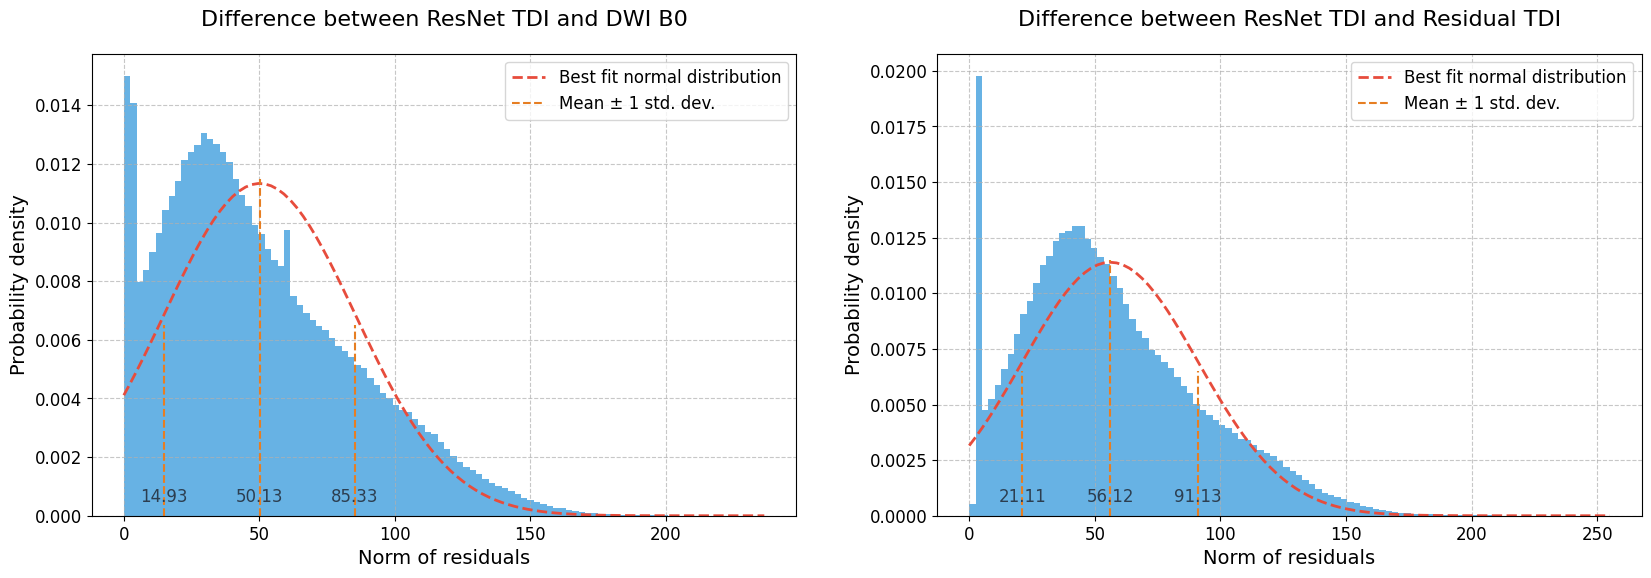

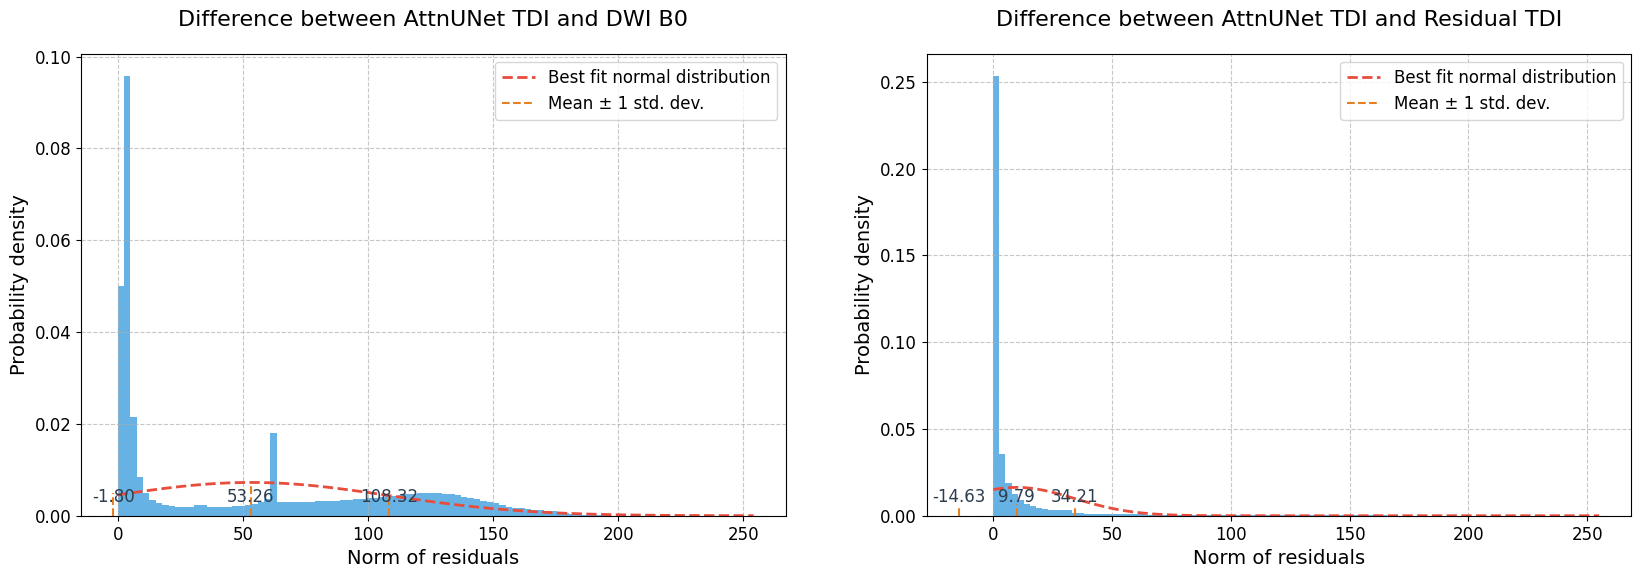

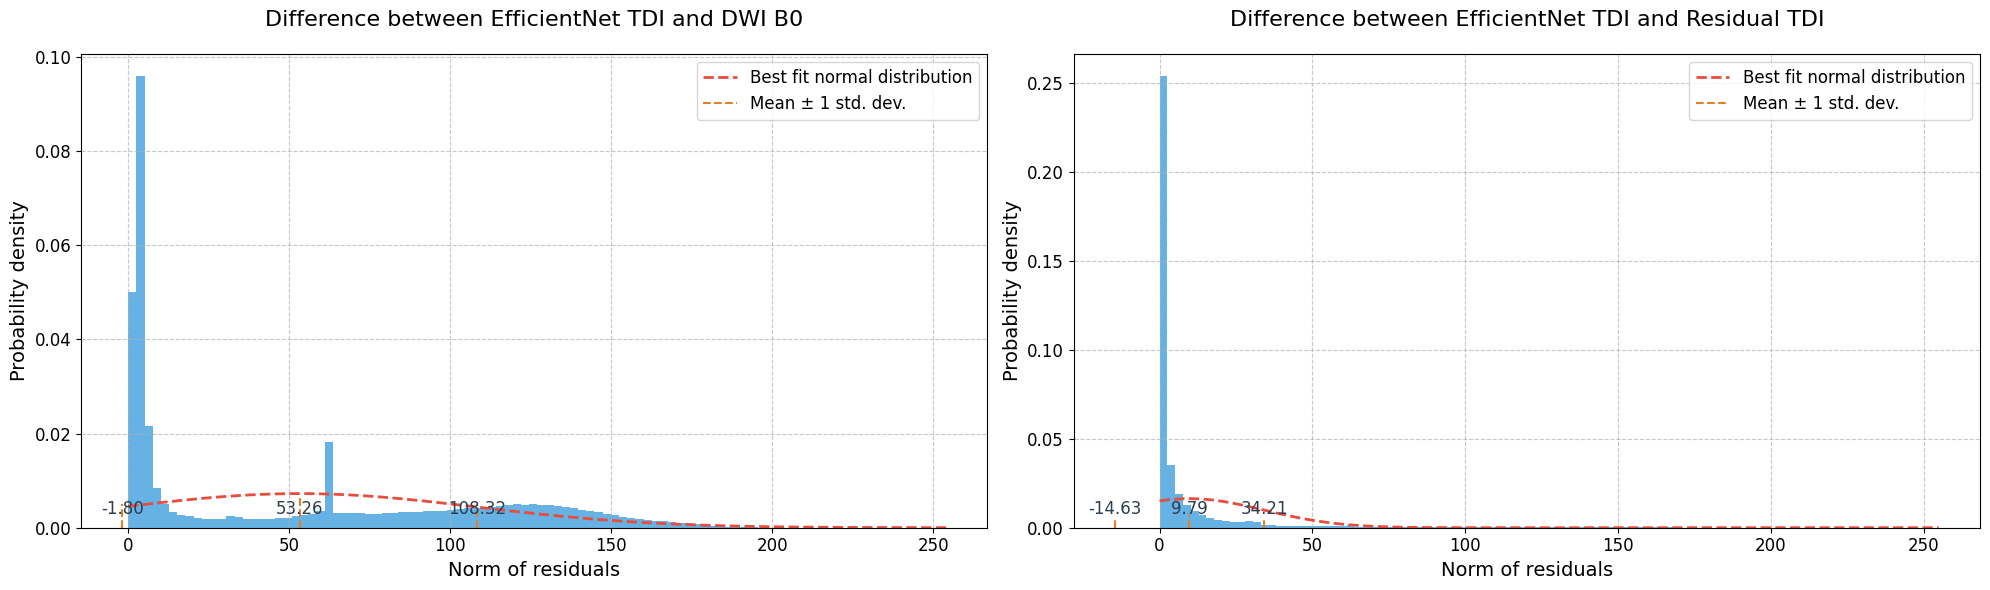

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Soft color palette
hist_color = '#3498db'  # blue
line_color = '#e74c3c'  # red
mean_color = '#2c3e50'  # dark gray
annotation_color = '#e67e22'  # orange

# Lists to loop over
conditions = [('DWI B0', B0_differences, B0_means, B0_stds, B0_medians), ('Residual TDI', RES_differences, RES_means, RES_stds, RES_medians)]
prob_maxes = [
    [0.0065, 0.0115, 0.0065],  # ResNet
    [0.005, 0.007, 0.005],  # AttnUNet
    [0.005, 0.007, 0.005]   # EfficientNet
]

model_names = ['ResNet', 'AttnUNet', 'EfficientNet']

for row in range(3):  # Looping over 3 models
    # Set up the figure and axes for each model
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    for col, (label, differences, means, stds, medians) in enumerate(conditions):
        ax = axes[col]  # Now just select the column because there's only one row

        diff = differences[row]
        mean = means[row]
        std = stds[row]
        median = medians[row]
        max_prob = prob_maxes[row]

        print("Row: {:02} | Col: {:02} | Mean: {:05.2f} | Std: {:05.2f} | Max prob: {}".format(row, col, mean, std, max_prob))

        # Histogram of residuals
        n, bins, patches = ax.hist(diff, bins=100, density=True, color=hist_color, alpha=0.75)

        # Add a 'best fit' line
        y = norm.pdf(bins, mean, std)
        ax.plot(bins, y, '--', color=line_color, linewidth=2, label='Best fit normal distribution')

        # Add vertical lines for the mean and one standard deviation on either side
        ax.vlines(mean - std, 0, max_prob[0], color=annotation_color, linestyle='dashed', linewidth=1.5)
        ax.vlines(mean, 0, max_prob[1], color=annotation_color, linestyle='dashed', linewidth=1.5)
        ax.vlines(mean + std, 0, max_prob[2], color=annotation_color, linestyle='dashed', linewidth=1.5, label='Mean ± 1 std. dev.')

        # Annotate the mean and std values on the x-axis
        ax.annotate(f'{mean:.2f}', (mean, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)
        ax.annotate(f'{mean + std:.2f}', (mean + std, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)
        ax.annotate(f'{mean - std:.2f}', (mean - std, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)

        # Improve labels and title
        ax.set_xlabel('Norm of residuals', fontsize=14)
        ax.set_ylabel('Probability density', fontsize=14)
        ax.set_title(f'Difference between {model_names[row]} TDI and {label}', fontsize=16, pad=20)

        # Adding a grid for better readability
        ax.grid(True, linestyle='--', which='both', alpha=0.7, zorder=0)

        # Position the legend optimally and set its fontsize
        ax.legend(loc='upper right', fontsize=12)

        # Increase tick font size
        ax.tick_params(axis='both', labelsize=12)

# Ensure everything fits without clipping
fig.tight_layout()

# Display the plot
plt.show()

        

Row:  0  | Col:  0  | Mean:  50.13  | Std:  35.2  | Max prob:  [0.0065, 0.0115, 0.0065]
Row:  0  | Col:  1  | Mean:  56.12  | Std:  35.01  | Max prob:  [0.0065, 0.0115, 0.0065]
Row:  1  | Col:  0  | Mean:  53.26  | Std:  55.06  | Max prob:  [0.02, 0.015, 0.01]
Row:  1  | Col:  1  | Mean:  9.79  | Std:  24.42  | Max prob:  [0.02, 0.015, 0.01]
Row:  2  | Col:  0  | Mean:  53.26  | Std:  55.06  | Max prob:  [0.02, 0.015, 0.01]
Row:  2  | Col:  1  | Mean:  9.79  | Std:  24.42  | Max prob:  [0.02, 0.015, 0.01]


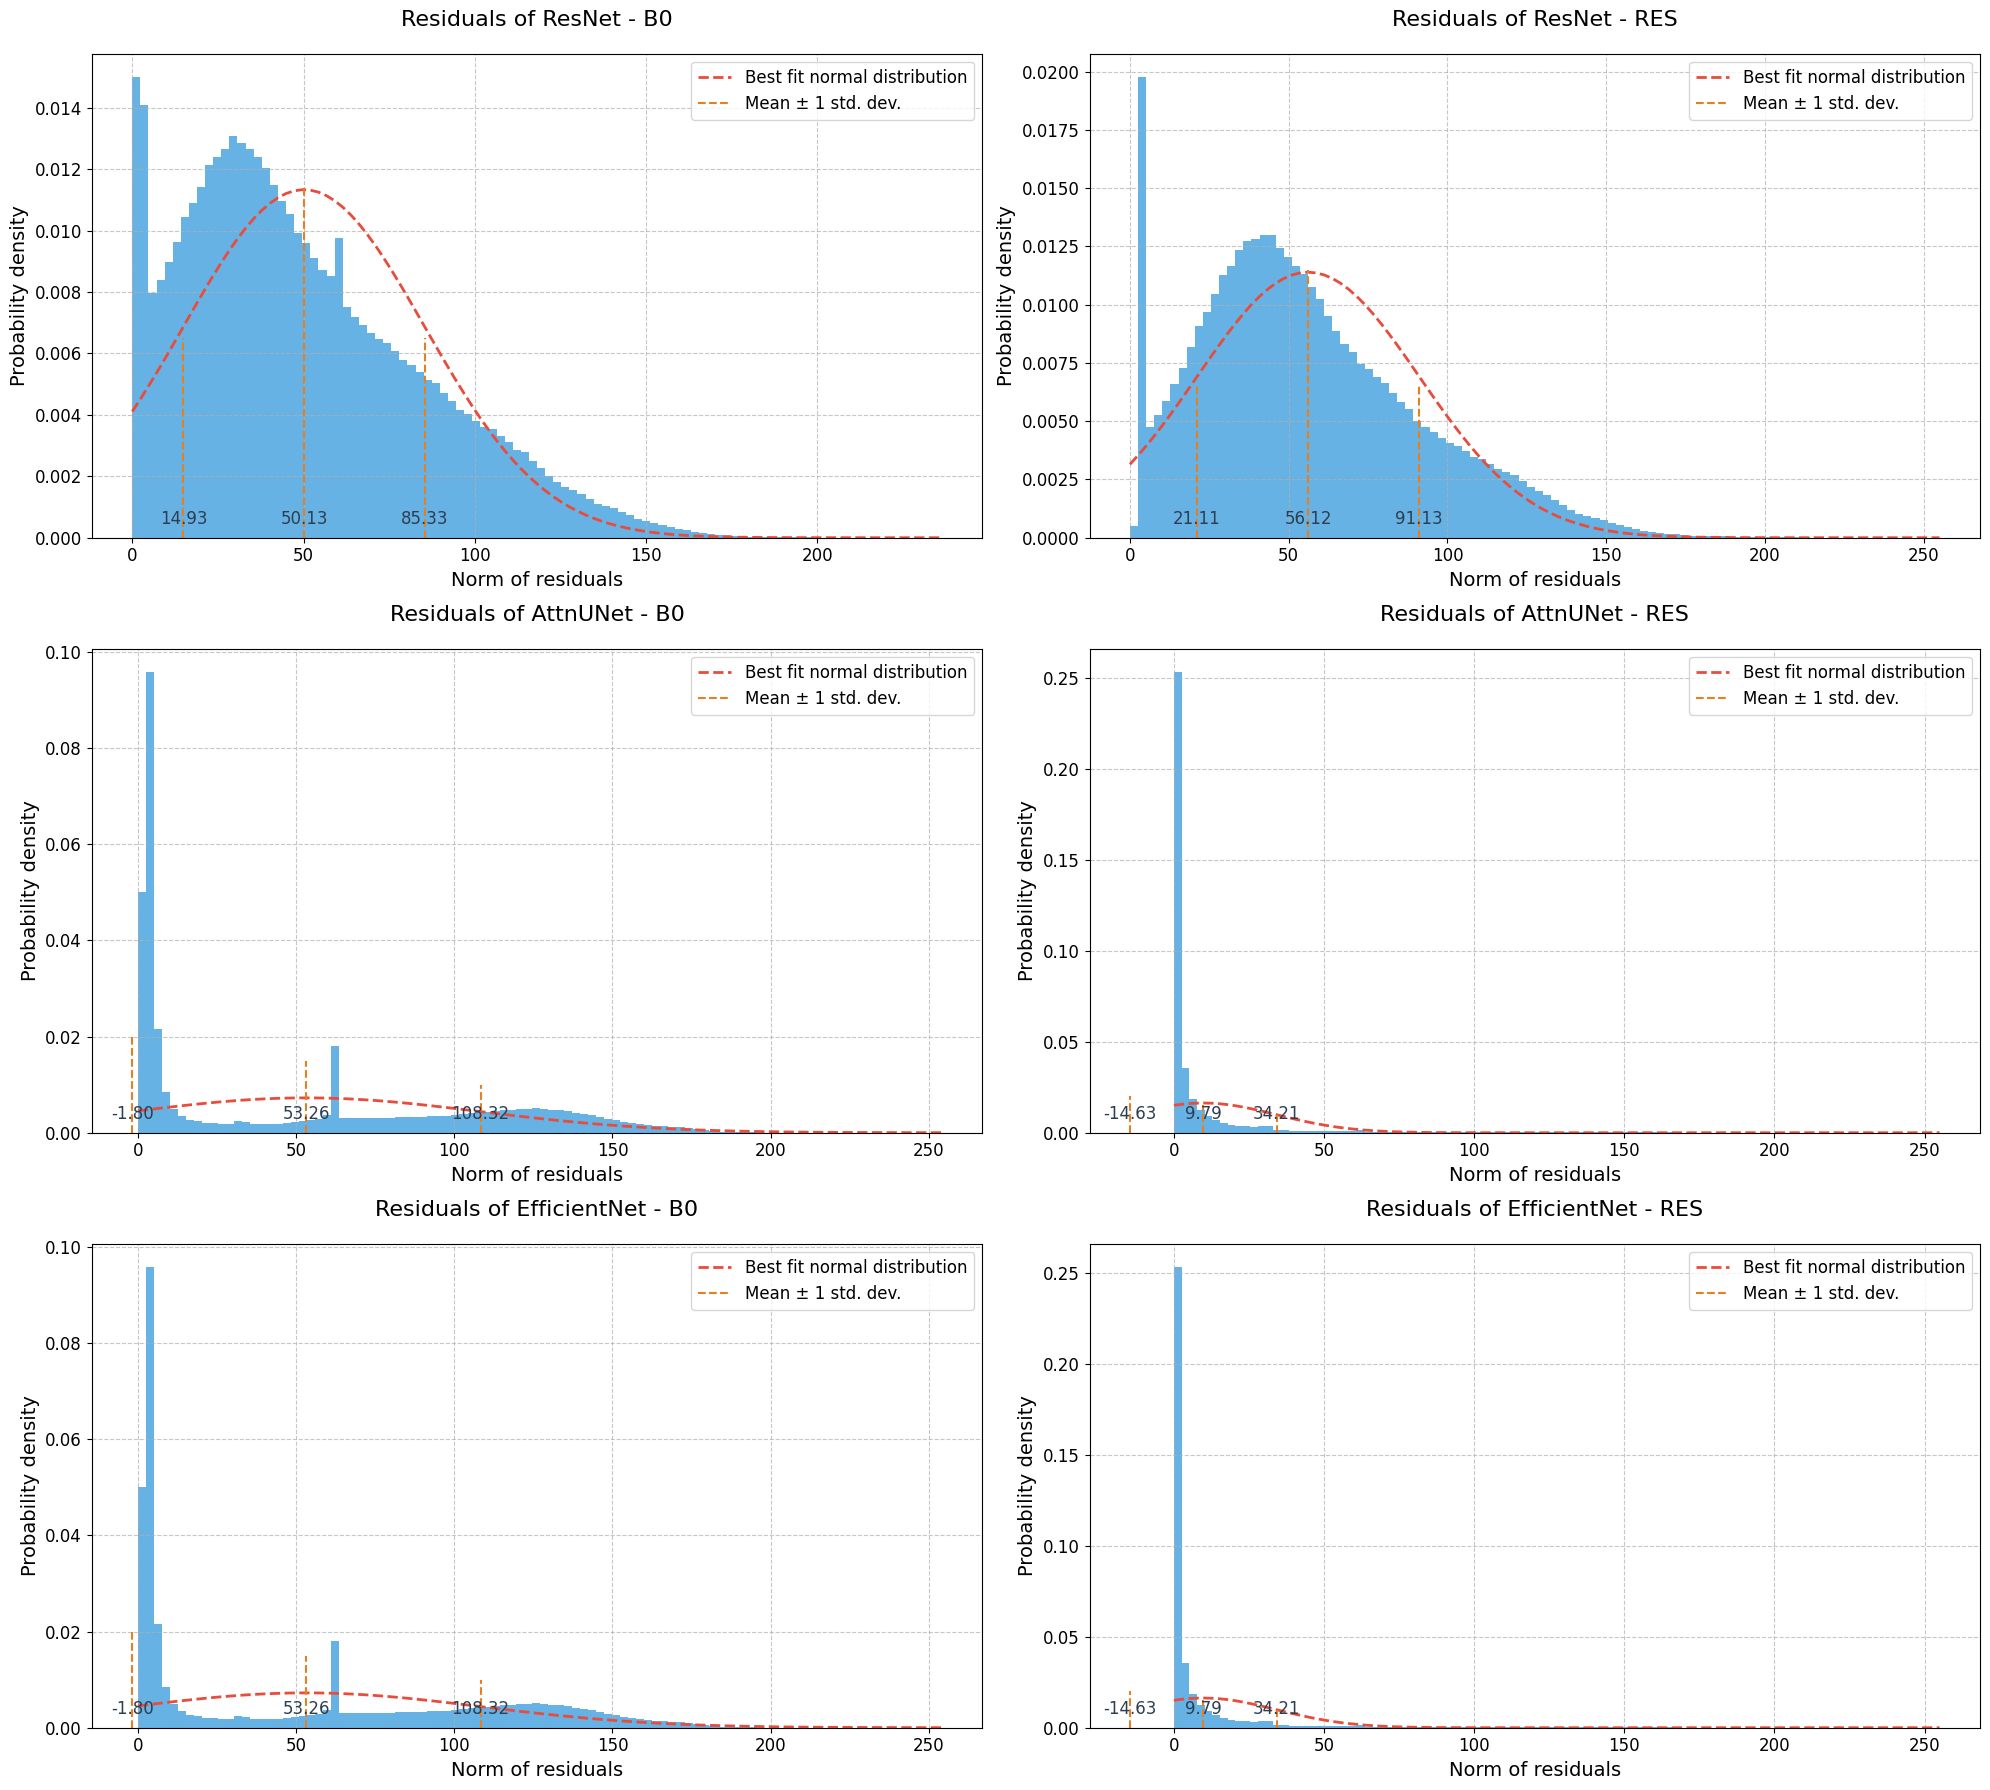

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set up the figure and axes
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# Soft color palette
hist_color = '#3498db'  # blue
line_color = '#e74c3c'  # red
mean_color = '#2c3e50'  # dark gray
annotation_color = '#e67e22'  # orange

# Lists to loop over
conditions = [('B0', B0_differences, B0_means, B0_stds), ('RES', RES_differences, RES_means, RES_stds)]
prob_maxes = [
    [0.0065, 0.0115, 0.0065],  # ResNet
    [0.02, 0.015, 0.01],  # AttnUNet
    [0.02, 0.015, 0.01]   # EfficientNet
]

model_names = ['ResNet', 'AttnUNet', 'EfficientNet']

for row in range(3):  # Looping over 3 models
    for col, (label, differences, means, stds) in enumerate(conditions):

        # Get the axes for each model
        ax = axes[row, col]

        diff = differences[row]
        mean = means[row]
        std = stds[row]
        max_prob = prob_maxes[row]

        print("Row: ", row, " | Col: ", col, " | Mean: ", mean, " | Std: ", std, " | Max prob: ", max_prob)

        # Histogram of residuals
        n, bins, patches = ax.hist(diff, bins=100, density=True, color=hist_color, alpha=0.75)

        # Add a 'best fit' line
        y = norm.pdf(bins, mean, std)
        ax.plot(bins, y, '--', color=line_color, linewidth=2, label='Best fit normal distribution')

        # Add vertical lines for the mean and one standard deviation on either side
        ax.vlines(mean - std, 0, max_prob[0], color=annotation_color, linestyle='dashed', linewidth=1.5)
        ax.vlines(mean, 0, max_prob[1], color=annotation_color, linestyle='dashed', linewidth=1.5)
        ax.vlines(mean + std, 0, max_prob[2], color=annotation_color, linestyle='dashed', linewidth=1.5, label='Mean ± 1 std. dev.')

        # Annotate the mean and std values on the x-axis
        ax.annotate(f'{mean:.2f}', (mean, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)
        ax.annotate(f'{mean + std:.2f}', (mean + std, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)
        ax.annotate(f'{mean - std:.2f}', (mean - std, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)

        # Improve labels and title
        ax.set_xlabel('Norm of residuals', fontsize=14)
        ax.set_ylabel('Probability density', fontsize=14)
        ax.set_title(f'Residuals of {model_names[row]} - {label}', fontsize=16, pad=20)

        # Adding a grid for better readability
        ax.grid(True, linestyle='--', which='both', alpha=0.7, zorder=0)

        # Position the legend optimally and set its fontsize
        ax.legend(loc='upper right', fontsize=12)

        # Increase tick font size
        ax.tick_params(axis='both', labelsize=12)

# Ensure everything fits without clipping
fig.tight_layout()

# Display the plot
plt.show()


In [ ]:
from ssim import *